#import e ajustes inmet

In [ ]:
import requests

url = "https://apitempo.inmet.gov.br/estacao/2022-06-1/2022-06-9/A201"
resultado = requests.get(url)
dados = resultado.json()

In [ ]:
import pandas as pd
import json

dados_str = json.dumps(dados)
dados_tabela = pd.read_json(dados_str)

dados_filtrados = dados_tabela[["DT_MEDICAO","HR_MEDICAO","TEM_INS","UMD_INS"]]

print(dados_filtrados)

     DT_MEDICAO  HR_MEDICAO  TEM_INS  UMD_INS
0    2022-06-01           0     23.7       98
1    2022-06-01         100     23.9       98
2    2022-06-01         200     24.0       98
3    2022-06-01         300     23.8       98
4    2022-06-01         400     23.8       98
..          ...         ...      ...      ...
211  2022-06-09        1900     30.7       74
212  2022-06-09        2000     23.3       96
213  2022-06-09        2100     23.4       97
214  2022-06-09        2200     23.4       97
215  2022-06-09        2300     23.3       96

[216 rows x 4 columns]


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

indice = pd.date_range("2022-06-01", freq = 'H', periods = 216)
indice = pd.to_datetime(indice)
#temperatura
temperatura = dados_filtrados["TEM_INS"]
temperatura.index = indice
#print(temperatura)
#umidade
umidade = dados_filtrados["UMD_INS"]
umidade.index = indice
#print(umidade)

#Imports e ajustes thingsboard

##obtenção tabela de umidade e temperatura não tratada

In [ ]:
!pip install tb-rest-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# ThingsBoard REST API URL
url = "https://demo.thingsboard.io"

# Default Tenant Administrator credentials
username = "gabriel.vieira10@yahoo.com.br"
password = "thingsboard123"
deviceID = "484df510-c402-11ec-942a-51543ec1dbaf"

In [ ]:
#conversão de data para UNIX timestamp
import datetime

def converte(data_string):
  data = datetime.datetime.strptime(data_string, "%d/%m/%Y")
  timestamp = int(datetime.datetime.timestamp(data)*1000)
  return timestamp
 
inicioTempo = converte("01/06/2022")
print(inicioTempo)
fimTempo = converte("10/06/2022")
print(fimTempo)

1654041600000
1654819200000


In [ ]:
!pip install tb-rest-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tb_rest_client.rest_client_ce as tb
import pandas as pd

cli = tb.RestClientCE(base_url=url)

cli.login(username=username, password=password)

#Mostra atributos de um dispositivo
atributos_lista = cli.get_attributes('DEVICE', deviceID, keys='latitude,longitude,altitude,stationCode')
atributosDF = pd.DataFrame(atributos_lista)
display(atributosDF)

""


In [ ]:
#Mostra séries temporais
series = cli.get_timeseries('DEVICE',deviceID,
                            keys='umidade,temperatura',limit=10000,
                            agg="AVG", interval=60*60*1000, #period=60*60, #média de hora em hora
                            start_ts=inicioTempo,end_ts=fimTempo)
print(series)
series_T = pd.DataFrame(series['temperatura'])
#display(series_T)
series_U = pd.DataFrame(series['umidade'])
#display(series_U)

{'umidade': [{'ts': 1654043400000, 'value': '68.33704735376044'}, {'ts': 1654047000000, 'value': '68.59002770083103'}, {'ts': 1654050600000, 'value': '69.00277777777778'}, {'ts': 1654054200000, 'value': '69.03611111111111'}, {'ts': 1654057800000, 'value': '69.00555555555556'}, {'ts': 1654061400000, 'value': '69.57381615598885'}, {'ts': 1654065000000, 'value': '70.0'}, {'ts': 1654068600000, 'value': '70.37950138504155'}, {'ts': 1654072200000, 'value': '71.33055555555555'}, {'ts': 1654075800000, 'value': '71.40389972144847'}, {'ts': 1654079400000, 'value': '72.02216066481995'}, {'ts': 1654083000000, 'value': '71.08077994428969'}, {'ts': 1654086600000, 'value': '70.14444444444445'}, {'ts': 1654090200000, 'value': '66.49030470914127'}, {'ts': 1654093800000, 'value': '65.09470752089136'}, {'ts': 1654097400000, 'value': '64.03611111111111'}, {'ts': 1654101000000, 'value': '60.33240997229917'}, {'ts': 1654104600000, 'value': '62.17777777777778'}, {'ts': 1654108200000, 'value': '63.63509749303

##Tratando tabela

In [ ]:
from datetime import datetime
from time import time;

In [ ]:
def datecorrect(x):
  if (type(x)==str):
    return x
  else:
    x = datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d %H:00:00')
    return x

In [ ]:
#Correção para temperatura
series_T['ts'] = [datecorrect(x) for x in series_T['ts']]
print(series_T) 

                      ts               value
0    2022-06-01 00:00:00  29.466852367688023
1    2022-06-01 01:00:00  29.562603878116345
2    2022-06-01 02:00:00   29.49138888888889
3    2022-06-01 03:00:00  29.409166666666664
4    2022-06-01 04:00:00              29.505
..                   ...                 ...
209  2022-06-09 19:00:00  32.533055555555556
210  2022-06-09 20:00:00  31.039166666666667
211  2022-06-09 21:00:00  29.669444444444444
212  2022-06-09 22:00:00  29.310555555555553
213  2022-06-09 23:00:00               29.05

[214 rows x 2 columns]


In [ ]:
#Ajust de indice e tipo do valor da temperatura 
from numpy import NaN
series_T['ts'] = pd.to_datetime(series_T['ts'])
series_T.index = series_T['ts']
series_T['value'] = series_T['value'].astype(float, errors = 'raise')
series_T = series_T['value']
series_T.columns = ["TEM_INS"]
series_T = series_T.rename_axis(index=None)
print(series_T)

2022-06-01 00:00:00    29.466852
2022-06-01 01:00:00    29.562604
2022-06-01 02:00:00    29.491389
2022-06-01 03:00:00    29.409167
2022-06-01 04:00:00    29.505000
                         ...    
2022-06-09 19:00:00    32.533056
2022-06-09 20:00:00    31.039167
2022-06-09 21:00:00    29.669444
2022-06-09 22:00:00    29.310556
2022-06-09 23:00:00    29.050000
Name: value, Length: 214, dtype: float64


In [ ]:
#Correção umidade
series_U['ts'] = [datecorrect(x) for x in series_U['ts']]
print(series_U) 

                      ts               value
0    2022-06-01 00:00:00   68.33704735376044
1    2022-06-01 01:00:00   68.59002770083103
2    2022-06-01 02:00:00   69.00277777777778
3    2022-06-01 03:00:00   69.03611111111111
4    2022-06-01 04:00:00   69.00555555555556
..                   ...                 ...
209  2022-06-09 19:00:00   58.82222222222222
210  2022-06-09 20:00:00  61.419444444444444
211  2022-06-09 21:00:00   64.25277777777778
212  2022-06-09 22:00:00   67.33333333333333
213  2022-06-09 23:00:00    68.5111111111111

[214 rows x 2 columns]


In [ ]:
#Ajuste de indice e tipo do valor umidade
series_U['ts'] = pd.to_datetime(series_U['ts'])
series_U.index = series_U['ts']
series_U['value'] = series_U['value'].astype(float, errors = 'raise')
series_U = series_U['value']
series_U.columns = ["UMD_INS"]
series_U = series_U.rename_axis(index=None)
print(series_U)

2022-06-01 00:00:00    68.337047
2022-06-01 01:00:00    68.590028
2022-06-01 02:00:00    69.002778
2022-06-01 03:00:00    69.036111
2022-06-01 04:00:00    69.005556
                         ...    
2022-06-09 19:00:00    58.822222
2022-06-09 20:00:00    61.419444
2022-06-09 21:00:00    64.252778
2022-06-09 22:00:00    67.333333
2022-06-09 23:00:00    68.511111
Name: value, Length: 214, dtype: float64


#Operações com as tabelas

In [ ]:
#temperatura inmet
#print(temperatura)

#umidade inmet
#print(umidade)

#temperatura thingsboard
#print(series_T)

#umidade thingsboard
#print(series_U)

In [ ]:
#concatenação
temp_na = pd.concat([series_T, temperatura], axis=1)
umidade_na = pd.concat([series_U, umidade], axis=1)
temp_na = temp_na.dropna()
umidade_na = umidade_na.dropna()

print(temp_na)
print(umidade_na)

                         value  TEM_INS
2022-06-01 00:00:00  29.466852     23.7
2022-06-01 01:00:00  29.562604     23.9
2022-06-01 02:00:00  29.491389     24.0
2022-06-01 03:00:00  29.409167     23.8
2022-06-01 04:00:00  29.505000     23.8
...                        ...      ...
2022-06-09 19:00:00  32.533056     30.7
2022-06-09 20:00:00  31.039167     23.3
2022-06-09 21:00:00  29.669444     23.4
2022-06-09 22:00:00  29.310556     23.4
2022-06-09 23:00:00  29.050000     23.3

[214 rows x 2 columns]
                         value  UMD_INS
2022-06-01 00:00:00  68.337047       98
2022-06-01 01:00:00  68.590028       98
2022-06-01 02:00:00  69.002778       98
2022-06-01 03:00:00  69.036111       98
2022-06-01 04:00:00  69.005556       98
...                        ...      ...
2022-06-09 19:00:00  58.822222       74
2022-06-09 20:00:00  61.419444       96
2022-06-09 21:00:00  64.252778       97
2022-06-09 22:00:00  67.333333       97
2022-06-09 23:00:00  68.511111       96

[214 rows x 2 c

In [ ]:
#Erro temperatura
Erro_T = temp_na['TEM_INS'] - temp_na['value']
print(Erro_T)
#Erro umidade
Erro_U = umidade_na['UMD_INS'] - umidade_na['value']
print(Erro_U)

2022-06-01 00:00:00   -5.766852
2022-06-01 01:00:00   -5.662604
2022-06-01 02:00:00   -5.491389
2022-06-01 03:00:00   -5.609167
2022-06-01 04:00:00   -5.705000
                         ...   
2022-06-09 19:00:00   -1.833056
2022-06-09 20:00:00   -7.739167
2022-06-09 21:00:00   -6.269444
2022-06-09 22:00:00   -5.910556
2022-06-09 23:00:00   -5.750000
Length: 214, dtype: float64
2022-06-01 00:00:00    29.662953
2022-06-01 01:00:00    29.409972
2022-06-01 02:00:00    28.997222
2022-06-01 03:00:00    28.963889
2022-06-01 04:00:00    28.994444
                         ...    
2022-06-09 19:00:00    15.177778
2022-06-09 20:00:00    34.580556
2022-06-09 21:00:00    32.747222
2022-06-09 22:00:00    29.666667
2022-06-09 23:00:00    27.488889
Length: 214, dtype: float64


In [ ]:
def modulo(x):
  if (x<0):
    return -x
  else:
    return x

In [ ]:
Erro_TC = [modulo(x) for x in Erro_T]
Erro_UC = [modulo(x) for x in Erro_U]
Erro_TC = pd.DataFrame(Erro_TC)
Erro_UC = pd.DataFrame(Erro_UC)
Erro_TC.index = Erro_T.index
Erro_UC.index = Erro_U.index
#print(Erro_TC)
#print(Erro_UC)
Erro_T = Erro_TC
Erro_U = Erro_UC

#Gráficos e sumarização

In [ ]:
#sumarização

Erro_T.describe()
#contagem
#media
#desvio padrão
#mínimo
#1°quartil
#Mediana
#3°quartil
#máximo

,0
count,214.000000
mean,4.461670
std,2.092468
min,0.014444
25%,2.504755
50%,5.466111
75%,6.088681
max,7.739167


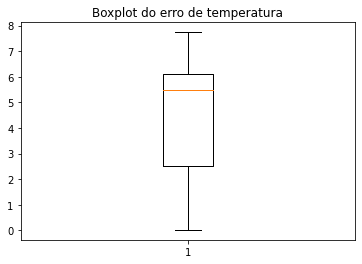

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.boxplot(Erro_T[0])
ax.set_title('Boxplot do erro de temperatura')
plt.show()

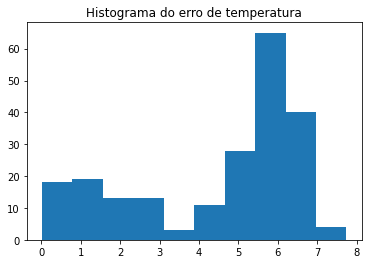

In [ ]:
#Histograma temperatura

fig, ax = plt.subplots()
ax.hist(Erro_T[0], bins = 10)
ax.set_title('Histograma do erro de temperatura')
plt.show()

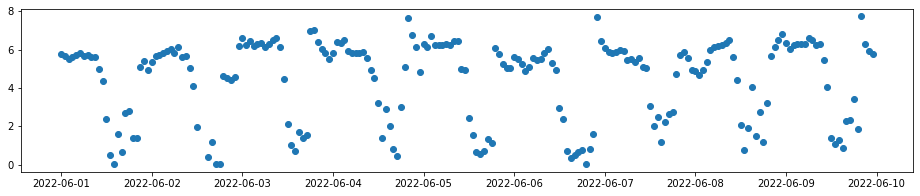

In [ ]:
#Gráfico de dispersão

plt.figure(figsize=(16,3))
plt.scatter(Erro_T.index, Erro_T[0])
plt.show()

In [ ]:
#Sumarização

Erro_U.describe()
#contagem
#media
#desvio padrão
#mínimo
#1°quartil
#Mediana
#3°quartil
#máximo

,0
count,214.000000
mean,23.115179
std,9.237674
min,1.461111
25%,14.422288
50%,27.350000
75%,29.665738
max,38.366667


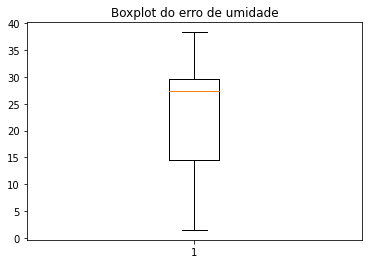

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(Erro_U[0])
ax.set_title('Boxplot do erro de umidade')
plt.show()

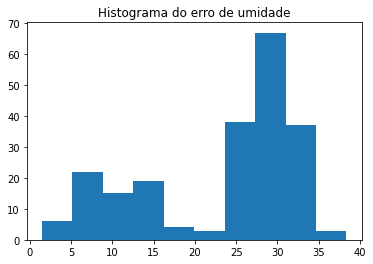

In [ ]:
#Histograma do erro de umidade

fig, ax = plt.subplots()
#bins são o numero de agrupamentos
ax.hist(Erro_U[0], bins = 10)
ax.set_title('Histograma do erro de umidade')
plt.show()

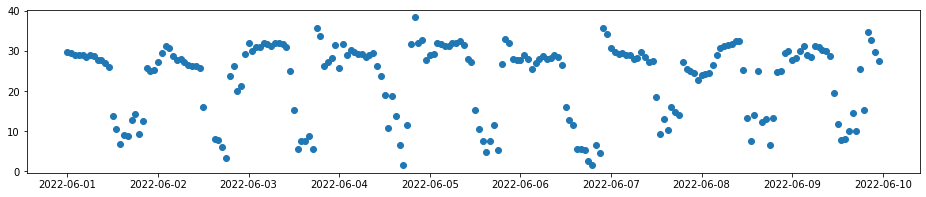

In [ ]:
#Gráfico de dispersão

plt.figure(figsize=(16,3))
plt.scatter(Erro_U.index, Erro_U[0])
plt.show()